In [12]:
import imageio
import numpy as np
import pandas as pd
from skimage.io import imread
import cv2
from PIL import Image
from sklearn import preprocessing
import cvxopt 
import mosek
import cvxpy as cp
import scipy as scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pygsp import graphs


In [119]:
class TFOG:
    def __init__(self, k, signal, graph_size):
        
        self.k = k # order of delta
        self.signal = signal # input signal
        self.graph_size = graph_size # graph size(n*n)
        self.size = signal.size # signal size
        self.X = cp.Variable(shape=(self.size,)) # Variale type for solver (CVXOPT)
        
        # creation of graph
        self.g = graphs.Grid2d(self.graph_size, self.graph_size) 
        xx, yy = np.meshgrid(np.arange(self.graph_size), np.arange(self.graph_size))
        self.coords = np.array((xx.ravel(), yy.ravel())).T
        self.g.set_coordinates(self.coords)

        
     
    # subfunction count nb of 1 (edges) in matrix
    def __count_one(self,x):
        tmp = 0
        for i in range(len(x)):
            for j in range(len(x)):
                if x[i][j] == 1:
                    tmp +=1
        return tmp
    # incidence to delta function
    def __inc_to_delta(self,inc):
        n = len(inc) 
        k = 0
        size = int(self.__count_one(inc)/2)
        tmp = [np.zeros(n) for i in range(size)]
        for i in range(n):
            # inc matrix is symetric
            for j in range(i,n):
                if inc[i][j] == 1:
                    tmp[k][i] = -1
                    tmp[k][j] = 1
                    k+=1

        return tmp
    
           
        
    # graph to inc matrix
    def inc_mat(self):
        return self.g.W.toarray()
    
    # graph difference order function : Dk+1 = D1^T @ Dk if odd k and Dk+1 = D1 @ Dk if even k (D0 makes no sens)
    def __GDO(self,delta, k):
        if k == 1:
            return delta
        elif k%2 == 0:
            return np.dot(np.transpose(delta), self.__GDO(delta, k-1))
        elif k%2 == 1:
            return np.dot(delta, self.__GDO(delta, k-1))
    # delta1 function
    def delta1(self):
        return self.__inc_to_delta(self.inc_mat())
        
    # deltak function
    def deltak(self):
        
        return np.array(self.__GDO(self.delta1(), self.k))
        
    

    # check if a list of list already contains another list
    def __in_list(x, L):
        tmp2 = False
        for y in L:
            tmp1 = True
            for i in range(len(x)):
                #avoid repetition 
                tmp1 = (tmp1 and np.abs(x[i]) == np.abs(y[i])) 
            tmp2 = (tmp2 or tmp1)
        return tmp2


    # plot the graph signal, can display edges with difference, the diff matrix may have some small data (1e-7 for example) instead of 0, accu is here to eliminate them
    def plot(self, show_border = True, accu = 1e1):
        if show_border:
            
            diff = np.dot(self.deltak(),self.X.value)
            
            color=[]    
            for i in range(len(diff)):

                if np.abs(diff[i]) < accu:
                    diff[i] = 0
                    color.append((0,0,0,0.1))
                else:
                    
                    color.append((1,0,0,1))
            self.g.plot_signal(self.signal, edge_color = color)
        else:    
            self.g.plot_signal(self.signal)
    
    # solve the pb using CVXOPT
    def solve(self, Verbose = False, vlambda = 50):
        print(vlambda)
        print(f'd = {self.deltak().shape} ')
        X = cp.Variable(shape=(self.size,))
        obj = cp.Minimize(0.5 * cp.norm(self.signal - X,2)**2 
                  + vlambda * cp.norm(self.deltak()@X, 1) )
        prob = cp.Problem(obj)
        prob.solve(solver=cp.CVXOPT, verbose=Verbose)
        self.X = X
        
    # estimate diff matrix
    def diff(self):
        return self.deltak()@self.X.value
    
    
    # plot the noisy input, the output and the ouput with edge diff
    def summary(self, accu =1e1, vlambda = 50):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        self.solve(vlambda = vlambda)
        self.g.plot_signal(self.signal, ax = ax[0])
        
        ax[0].set_title("Noisy input")
        self.g.plot_signal(self.X.value,ax = ax[1])
        diff = np.dot(self.deltak(),self.X.value)
        ax[1].set_title(f"Ouput k ={self.k - 1}" )
        color=[]    
        for i in range(len(diff)):

            if np.abs(diff[i]) < accu:
                diff[i] = 0
                color.append((0,0,0,0.1))
            else:
                    
                color.append((1,0,0,1))
        self.g.plot_signal(self.X.value, edge_color = color, ax = ax[2])
        ax[2].set_title("Difference edges colored Ouput")
        print(self.k)
        
        #self.g.plot_signal(self.X.value,ax = ax[1], limits = [min(self.X.value), max(self.X.value)])
        
        
        
    
        plt.show()
    # Return the value of the solution
    def values(self):
        return self.X.value
    
    # genrealized  inverse function (extend to rectangular matrix)
    def __generalized_inverse(self, mat):
        return np.linalg.inv(np.transpose(mat) @ mat) @ np.transpose(mat)
    
    # estimate lambda max
    def lambda_max(self):
   
        lmda_max= 0.0
   
    
        if self.k%2 == 0:
       
            lmda_max= np.linalg.norm(np.transpose(np.linalg.inv(self.deltak()))@self.signal, np.inf)
        else:
        
            lmda_max = np.linalg.norm(np.transpose(self.__generalized_inverse(self.deltak()))@self.signal, np.inf)
    
        return lmda_max
    
    def plot_3d(self):
        fig =  plt.figure(figsize=(20,5))
        ax3d = plt.axes(projection='3d')
        ax3d.plot_trisurf(self.coords[:,0], self.coords[0:,1] ,self.X.value, cmap=plt.cm.Spectral)

        plt.show()
    
        
        
        
        
        
        
        
    
        
    
    
    


Let $ G = (V,E)$ be an graph, with vertices $V = \{1,...,n\}$ and undirected edges $E = \{e_1,...e_n\}$ and suppose that we observe $y = (y_1,...y_n) \in \mathbb{R}^n$ over the nodes. We define the $k$th order \textif{graph trend filtering} estimate $\hat{\beta} = (\hat{\beta}_1,...,\hat{\beta}_n)$ by 

 
 
$$\hat{\beta}= \underset{\beta \in \mathbb{R}^n}{\operatorname{ argmin}} \frac{1}{2} ||y-\beta||_2^2 + \lambda||\Delta^{(k+1)}\beta||_1$$

When $k = 0$, we define first order graph difference operator $\Delta^{(1)}$ in such way it yields the graph equivalent of a penalty on local differences :

$$||\Delta^{(1)} \beta||_1 = \underset{(i,j) \in E}{\operatorname{ \Sigma}} |\beta_i - \beta_j|$$

Let $\Delta^{(1)}_l \in \{-1,0,1\}^{m*n}$ be the oriented incidence matrix of the graph $G$, containing one row for each edge in the graph. ex : if $e_l = (i,j)$, then $\Delta^{(1)}$ has $l$th row

$$ \Delta^{(1)}_l = (0,...,\underset{i}{\operatorname{ \underset{\uparrow}{\operatorname{ -1}}}},...,\underset{j}{\operatorname{ \underset{\uparrow}{\operatorname{ 1}}}},...,0)$$

For $k\ge 1$ we use a recursion to define the higher order graph difference operators, in a manner
similar to the univariate case. The recursion alternates in multiplying by the first difference operator $\Delta^{(1)}$ and its transpose (taking into account that this matrix not square)

$$
\Delta^{(k+1)} = \left\{
    \begin{array}{ll}
        (\Delta^{(1)})^T \Delta^{(k)}   \mbox{  for odd } k\\
        \Delta^{(1)} \Delta^{(k)}   \mbox{     for even } k
    \end{array}
\right.
$$

400
50
d = (760, 400) 
50
d = (760, 400) 
1


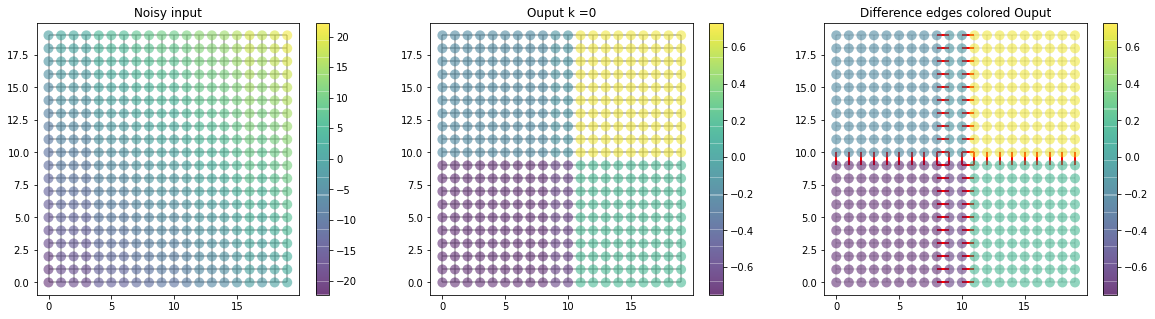

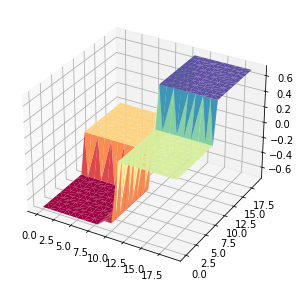

In [128]:
graph_size = 20
x = np.linspace(-10, 10, graph_size)
y = np.linspace(-10, 10, graph_size)
w = np.linspace(-10,10, graph_size**2)
xx, yy = np.meshgrid(x, y, sparse=True)
z_orig = xx+yy
#z_orig = (z_orig - min(z_orig))/(max(z_orig) - min(z_orig))
z_bruit = z_orig + np.random.normal(size=graph_size, loc = 0, scale = 1)
print(z_bruit.size)
#z_bruit += np.random.normal(size = graph_size, scale = 5)

prob_k_0 = TFOG(1, z_bruit.flatten(), graph_size)
prob_k_0.solve(vlambda = 50)
prob_k_0.summary(vlambda = 50, accu = 1e-4)
prob_k_0.plot_3d()



50
d = (400, 400) 
50
d = (400, 400) 
2


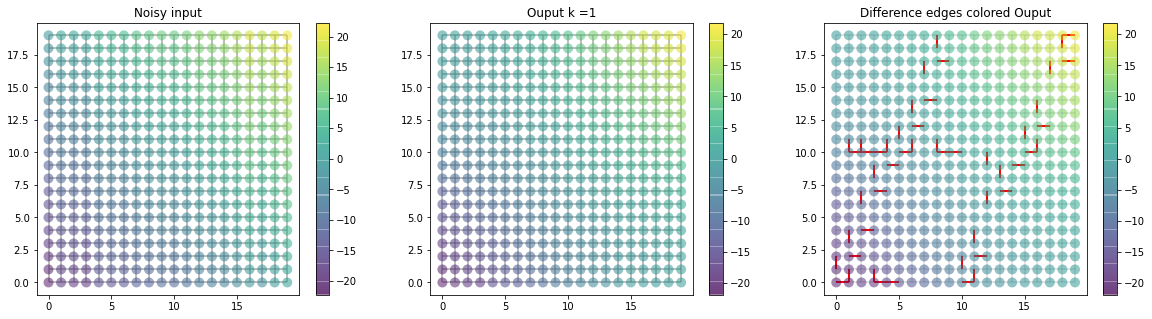

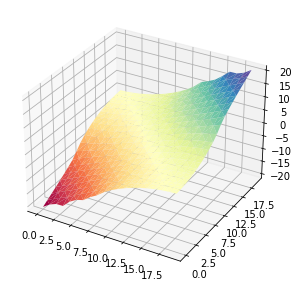

In [132]:
prob_k_1 = TFOG(2, z_bruit.flatten(), graph_size)
prob_k_1.solve(vlambda = 50)
prob_k_1.summary(vlambda = 50, accu = 1e-4)
prob_k_1.plot_3d()

50
d = (760, 400) 
50
d = (760, 400) 
3


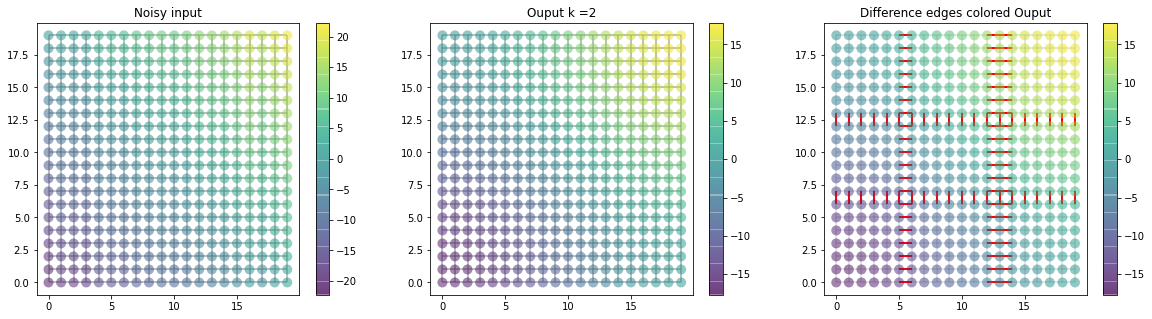

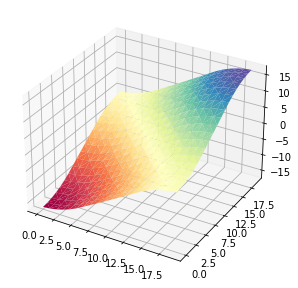

In [129]:
prob_k_2 = TFOG(3, z_bruit.flatten(), graph_size)
prob_k_2.solve(vlambda = 50)
prob_k_2.summary(vlambda = 50, accu = 1e-4)
prob_k_2.plot_3d()

50
d = (400, 400) 
50
d = (400, 400) 
4


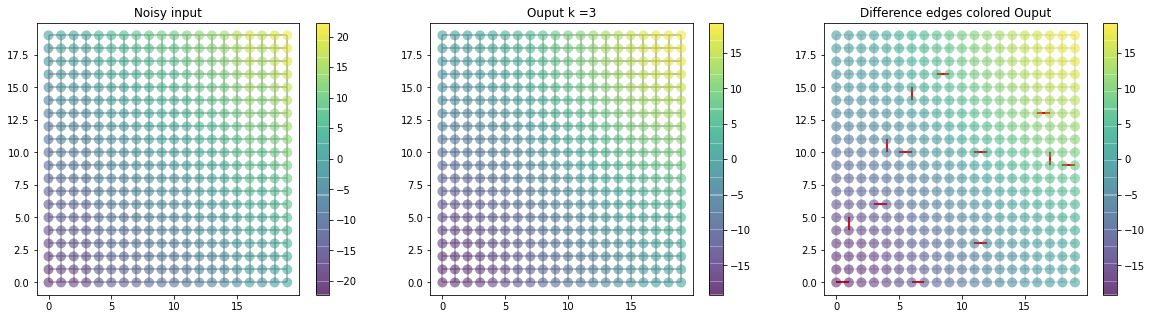

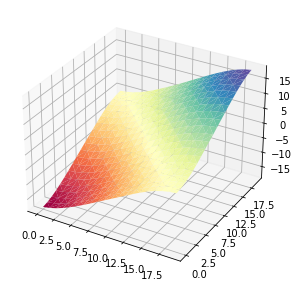

In [133]:
prob_k_3 = TFOG(4, z_bruit.flatten(), graph_size)
prob_k_3.solve(vlambda = 50)
prob_k_3.summary(vlambda = 50, accu = 1e-4)
prob_k_3.plot_3d()